Linear Regression notebook for EDF-Code Your Future Hackathon

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression

In [24]:
# Load in the energy.csv data
df = pd.read_csv("energy_noisy_train.csv")
df.head()

,Unnamed: 0,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,surface_area_categories,wall_description,energxe
0,223,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,High Surface Area,The wall colour is green and the area is 269.5...,571.0
1,285,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,Very High Surface Area,The wall colour is indigo and the area is 367....,NaN
2,350,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,Low Surface Area,The wall colour is orange and the area is 318....,NaN
3,363,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,Average Surface Area,The wall colour is orange and the area is 245....,395.0
4,551,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,Average Surface Area,The wall colour is indigo and the area is 416....,NaN


## Exploratory Data Analysis & Cleaning
We need to do an EDA as well as clean the dataset. First we clean the dataset with a little bit of EDA to understand the data. 

In [25]:
# This code checks the shape of the dataframe. I.e. (Rows, Columns)
df.shape

(538, 13)

We know from above that there are 538 Rows and 13 Columns

In [26]:
# Now we'll check the list of columns to see if we can make sense of it
list(df.columns)

['Unnamed: 0',
 'Relative Compactness',
 'Roof Area',
 'Overall Height',
 'Orientation',
 'Glazing Area',
 'Glazing Area Distribution',
 'Heating Load',
 'Cooling Load',
 'Location',
 'surface_area_categories',
 'wall_description',
 'energxe']

Make note, Unnamed:0 does not seem to mean anything at first glance, so we make note of this weird title, as a potential column to remove. It seems to be an old index from data saving etc. Everything else seems to serve a purpose and could contribute in what we want to predict. 

In [27]:
# We now have a quick look at the data
df.head()

,Unnamed: 0,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,surface_area_categories,wall_description,energxe
0,223,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,High Surface Area,The wall colour is green and the area is 269.5...,571.0
1,285,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,Very High Surface Area,The wall colour is indigo and the area is 367....,NaN
2,350,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,Low Surface Area,The wall colour is orange and the area is 318....,NaN
3,363,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,Average Surface Area,The wall colour is orange and the area is 245....,395.0
4,551,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,Average Surface Area,The wall colour is indigo and the area is 416....,NaN


From above it seems (at first glance) Unnamed: 0 is a random number, still making note of this. Other columns, although units are unknown, seem to be important. Making note that there are a few categorical columns without numbers: Location, surface area categories, and possibly wall description. energxe is also an odd column which seems has alot of nulls.

Make note that wall description has potentially useless data, i.e. the colour, and there is a number associated in each row. This could be useful. Make note to potentially extract colour and number from that column where possible

In [28]:
# Checking the data types so we understand the columns better
df.dtypes

Unnamed: 0                     int64
Relative Compactness         float64
Roof Area                    float64
Overall Height               float64
Orientation                    int64
Glazing Area                 float64
Glazing Area Distribution    float64
Heating Load                 float64
Cooling Load                 float64
Location                      object
surface_area_categories       object
wall_description              object
energxe                      float64
dtype: object

Most are floats and integers. The categorical is an object. We make note of this. 

We have 3 columns that seeem categorical with strings, we want to see if this would be useful for us in a ML model. If every category has about 200 unique entries, then its too unique for an ML model. 
See below:

In [29]:
STRING_COLUMNS = ['Location', 'surface_area_categories', 'wall_description']

for col in STRING_COLUMNS:
    number_unique = df[col].nunique()
    print(col)
    print(number_unique)

Location
5
surface_area_categories
5
wall_description
56


Wall Description has 56 unique values in that column, this cannot be used as a categorical column. And previously we noted that its data is a bit messy. This can be cleaned by isolating colour and number. As we spot this, we can do this now.

In [30]:
# Recode surface area and extract useful text from wall_description
def extract_figures(text, position = -3):
    # text <- string to extract information from
    # position <- integer that tells the position of number in string
    listOfWords = text.split()
    word = listOfWords[position]
    return word

df["Wall Area"] = df["wall_description"].apply(lambda x: float(extract_figures(x, -3)))
df["Colour"] = df["wall_description"].apply(lambda x: extract_figures(x, 4))
df.head()

,Unnamed: 0,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,surface_area_categories,wall_description,energxe,Wall Area,Colour
0,223,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,High Surface Area,The wall colour is green and the area is 269.5...,571.0,269.5,green
1,285,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,Very High Surface Area,The wall colour is indigo and the area is 367....,NaN,367.5,indigo
2,350,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,Low Surface Area,The wall colour is orange and the area is 318....,NaN,318.5,orange
3,363,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,Average Surface Area,The wall colour is orange and the area is 245....,395.0,245.0,orange
4,551,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,Average Surface Area,The wall colour is indigo and the area is 416....,NaN,416.5,indigo


As seen above, you've created colour column and Wall Area, we can now drop wall_description. Wall area is now a number and colour is categorical. 

In [31]:
df.drop(columns = 'wall_description', inplace = True)

In [32]:
# Checking that colour does not have too many categories:
df['Colour'].nunique()

8

8 is small enough to be considered a categorical column, however make note that colour probably has nothing to do with heating load (logically) so we should keep that in mind

Now we check the nulls.

<AxesSubplot:>

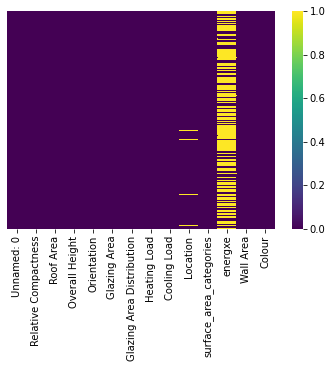

In [33]:
#Checking the Null values graphically
sns.heatmap(df.isnull(),yticklabels=False, cmap='viridis')

In [34]:
df.isnull().sum()

Unnamed: 0                     0
Relative Compactness           0
Roof Area                      0
Overall Height                 0
Orientation                    0
Glazing Area                   0
Glazing Area Distribution      0
Heating Load                   0
Cooling Load                   0
Location                       5
surface_area_categories        0
energxe                      349
Wall Area                      0
Colour                         0
dtype: int64

In [35]:
len(df)

538

You can drop those rows as its so small. and drop the column energxe as it has too many nulls to even derive a relationship.

Other ways to deal with nulls is to impute it with the average or median, but in this case. Not required. 

In [36]:
df.drop(columns = 'energxe', inplace = True)
df.dropna(inplace = True)

In [37]:
df.isnull().sum()

Unnamed: 0                   0
Relative Compactness         0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Location                     0
surface_area_categories      0
Wall Area                    0
Colour                       0
dtype: int64

Now data seems clean at a glance, we should start doing explorations to see if it can be cleaned more/if theres some redundent stuff in there. 

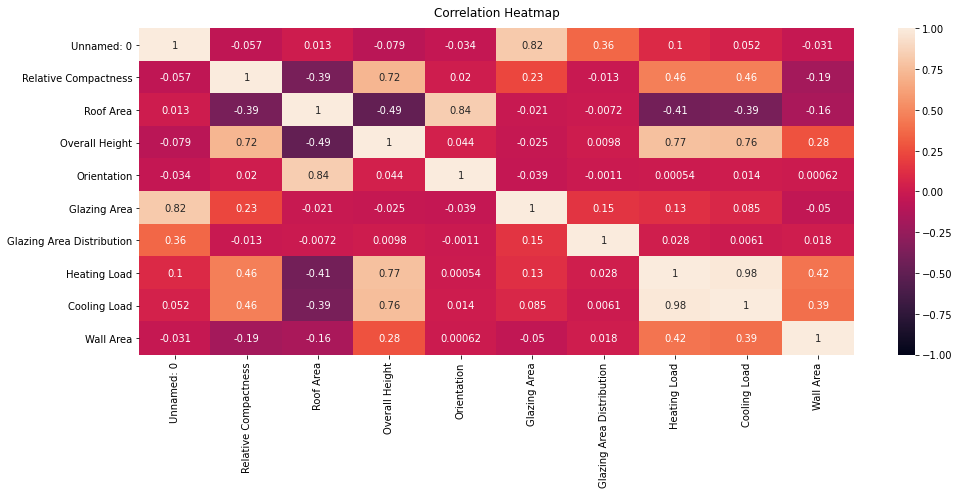

In [38]:
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

Explanation as to why we drop the unnamed, and note nothing really stands out with heating load.

Some explorations noting the categorical features. 

In [43]:
df.drop(columns = 'Unnamed: 0', inplace = True)

PAIRPLOT

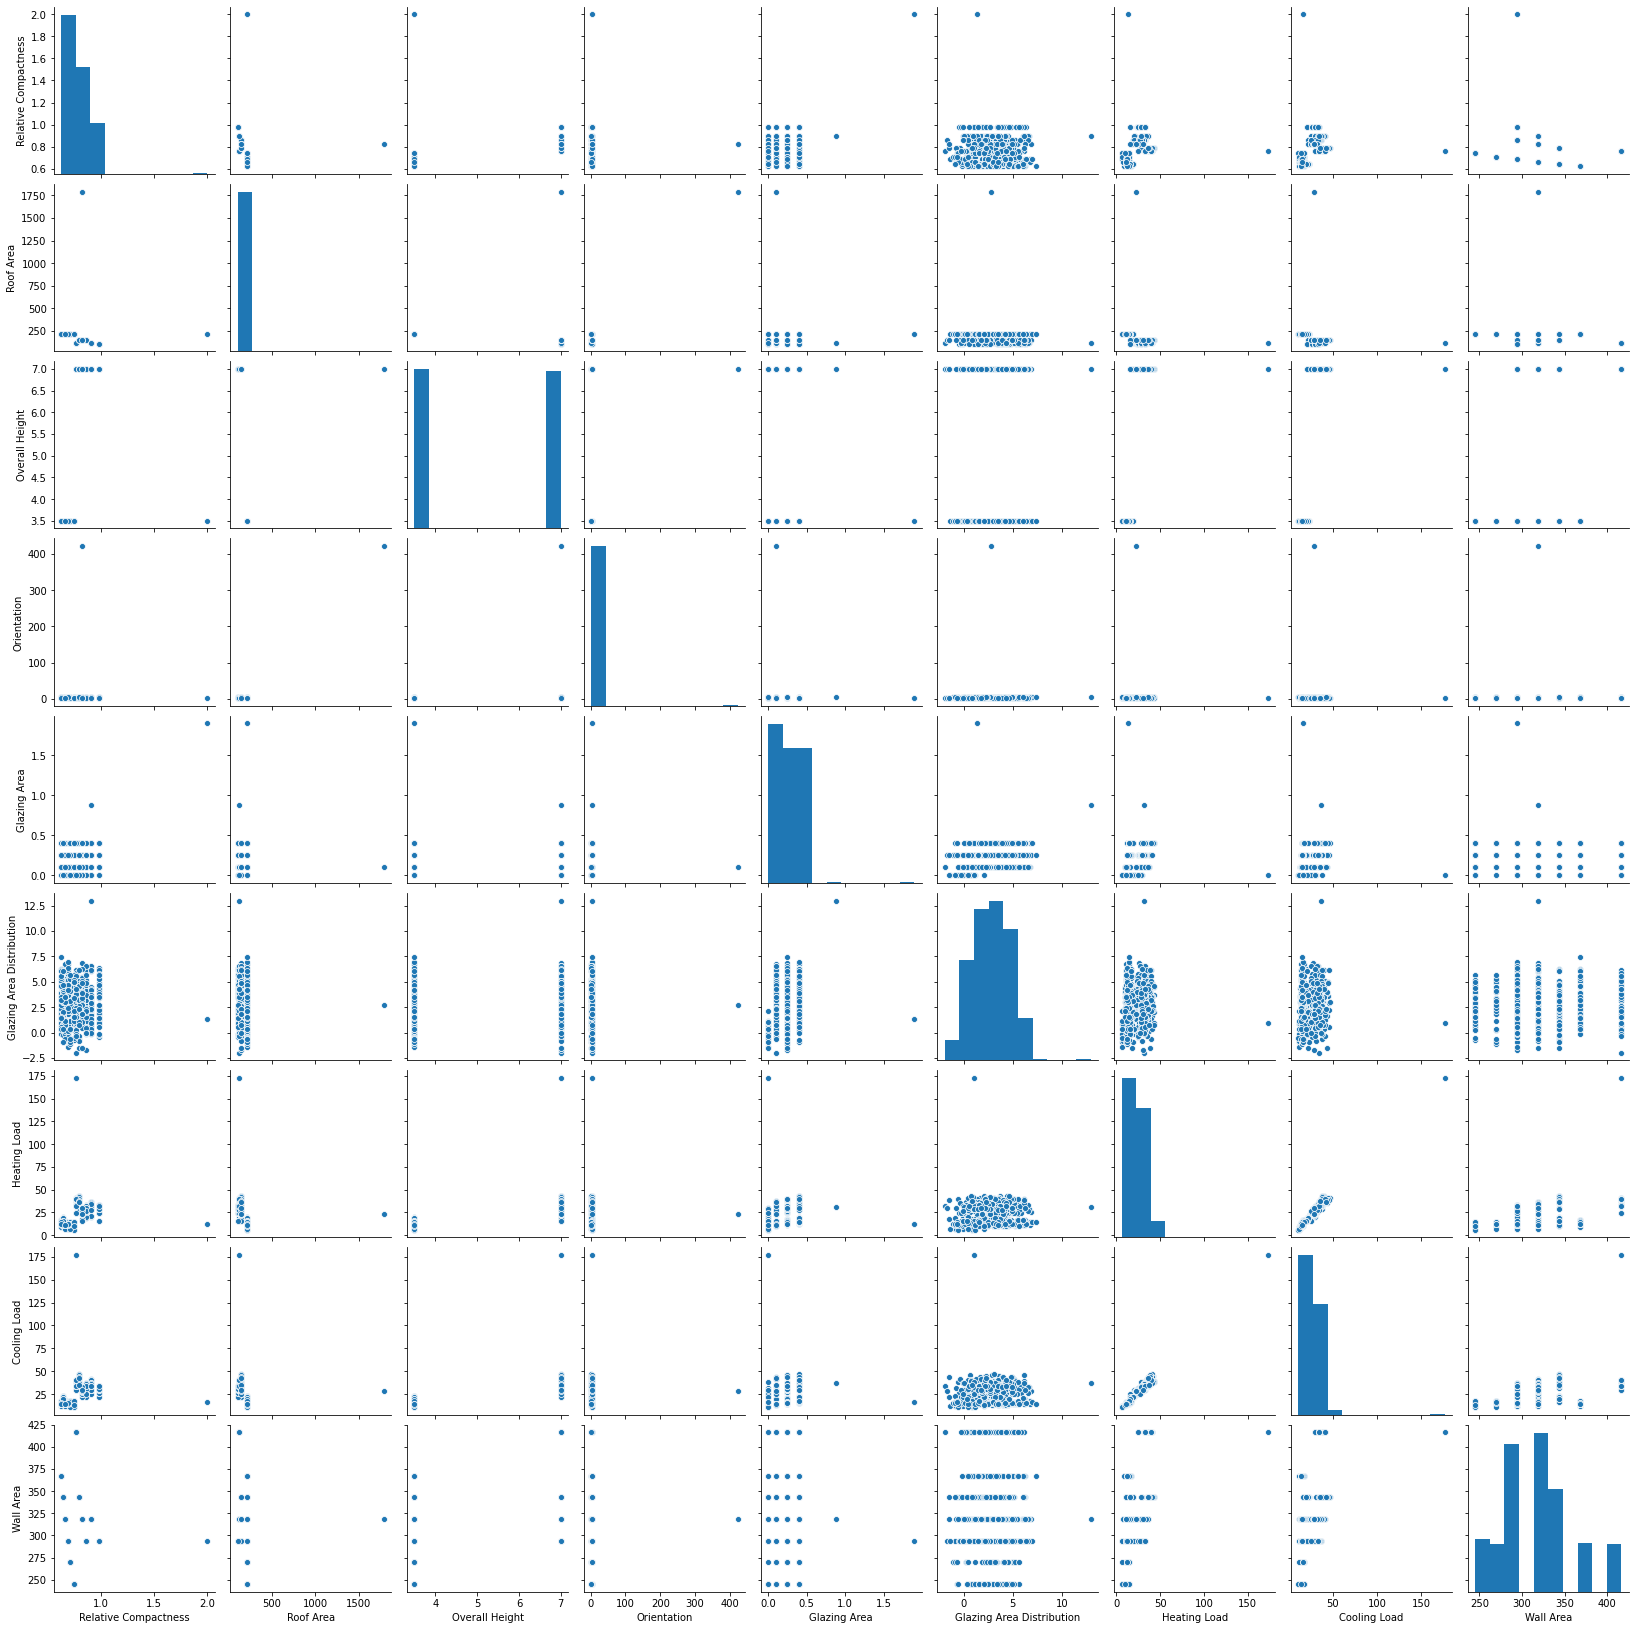

In [44]:
sns.pairplot(df)

BOXPLOTS TO GET ANOMALIES

In [ ]:
# Exploratory data analysis of energy.csv
for i, col in enumerate(df.columns):
    df[col].plot(fig=plt.figure(i))
    plt.title(col)

plt.show()

<AxesSubplot:xlabel='Relative Compactness'>

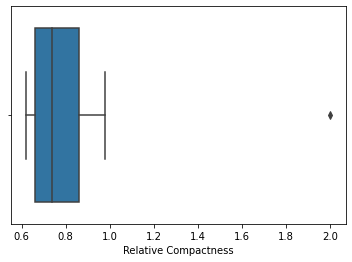

In [54]:
sns.boxplot(x=df['Relative Compactness'])

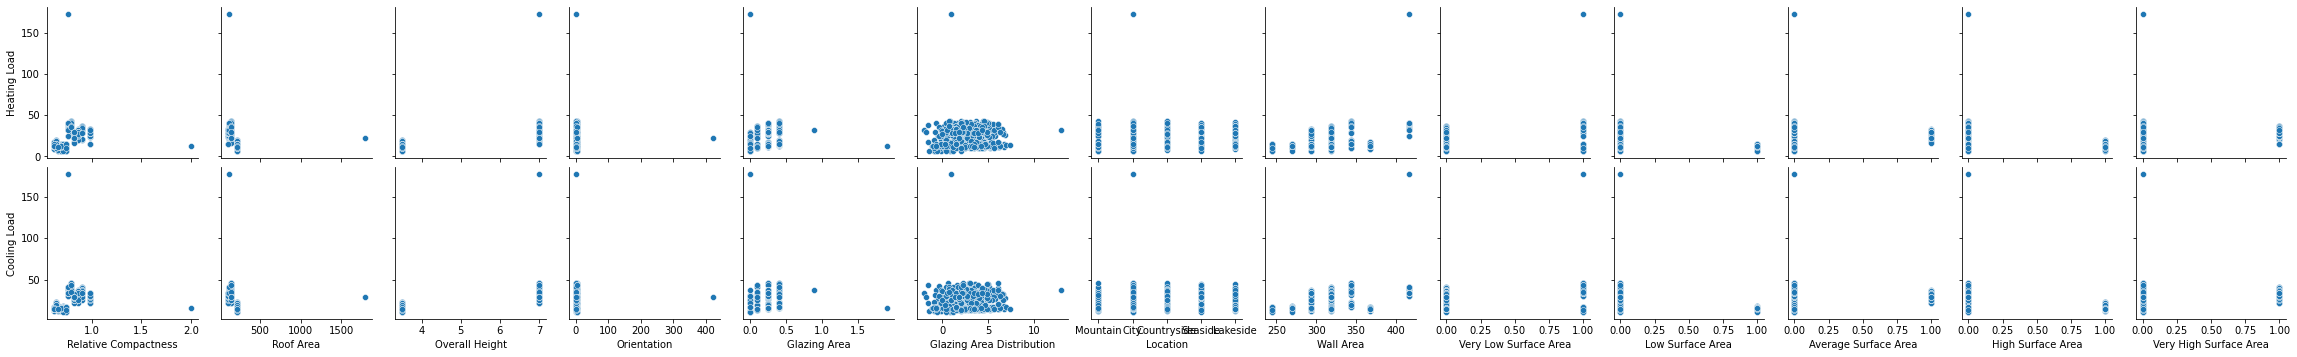

In [56]:
# Verify linear relationship
columns = list(df)

columns.remove("Heating Load")
columns.remove("Cooling Load")

g = sns.pairplot(df, 
                 x_vars=columns,
                 y_vars=["Heating Load", "Cooling Load"])

plt.show()

Take a look at the graphs above! Something stands out on the Relative Compactness, Roof Area, Overall Height and Orientation graphs! Those are likely extreme values and should be removed before proceeding to fit any machine learning model.

While we're at it - there are 2 extreme observations for the variables we want to predict (Heating & Cooling load) that we should remove as well.

In [57]:
df.drop(df[df["Relative Compactness"] > 1.5].index, inplace=True)
df.drop(df[df["Roof Area"] > 1000].index, inplace=True)
df.drop(df[df["Overall Height"] > 600].index, inplace=True)
df.drop(df[df["Orientation"] > 300].index, inplace=True)
df.drop(df[df["Glazing Area"] > 0.75].index, inplace=True)

df.drop(df[df["Heating Load"] > 100].index, inplace=True)
df.drop(df[df["Cooling Load"] > 100].index, inplace=True)

In [ ]:
sns.pairplot(df)

With categorical feature, you see that colour is just random, so we remove this. Plot the relative compactness vs heatingload, we see a good relationship there. Others are just linear regression needed. 

Then write a summary of the actions and data manipulation actions we did to get the model at a clean state to do the ML. and then run the ML, conclude there. 

In [56]:
df.head()

,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,surface_area_categories,Wall Area,Colour
0,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,High Surface Area,269.5,green
1,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,Very High Surface Area,367.5,indigo
2,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,Low Surface Area,318.5,orange
3,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,Average Surface Area,245.0,orange
4,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,Average Surface Area,416.5,indigo


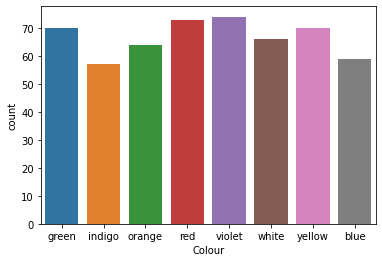

In [57]:
ax = sns.countplot(x="Colour", data=df)

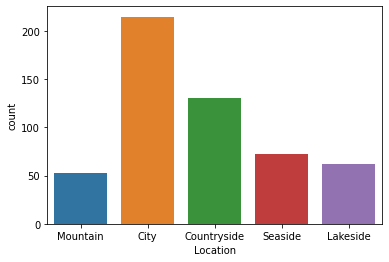

In [58]:
ax = sns.countplot(x="Location", data=df)

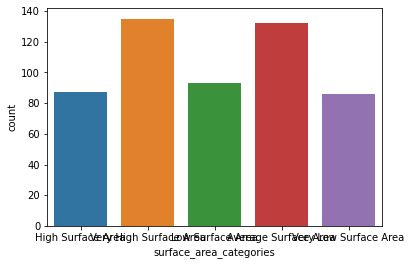

In [59]:
ax = sns.countplot(x="surface_area_categories", data=df)

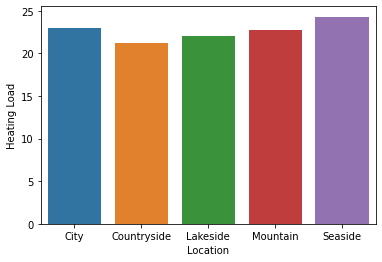

In [63]:
location_heating_average_rating  = df.groupby(by =['Location']).mean().reset_index()
ax=sns.barplot(x="Location", y="Heating Load", data=location_heating_average_rating)

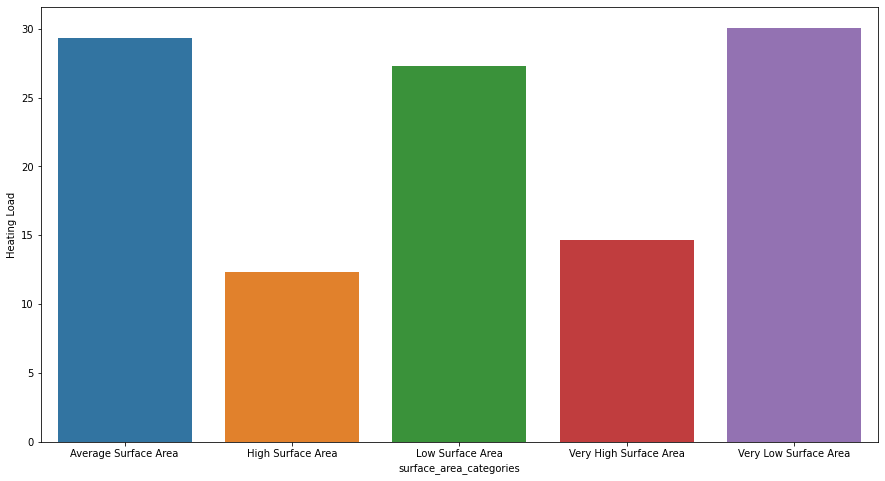

In [65]:
plt.figure(figsize=(15,8))
location_heating_average_rating  = df.groupby(by =['surface_area_categories']).mean().reset_index()
ax=sns.barplot(x="surface_area_categories", y="Heating Load", data=location_heating_average_rating)

In [20]:
df.drop(columns = 'Colour', inplace = True)

In [21]:
# Create dummy variables out of surface area categories
colNames = ["Very Low Surface Area", "Low Surface Area", "Average Surface Area", "High Surface Area", "Very High Surface Area"]

df[colNames] = pd.get_dummies(df["surface_area_categories"],dtype=int)

df.head()

,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,surface_area_categories,Wall Area,Very Low Surface Area,Low Surface Area,Average Surface Area,High Surface Area,Very High Surface Area
0,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,High Surface Area,269.5,0,1,0,0,0
1,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,Very High Surface Area,367.5,0,0,0,1,0
2,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,Low Surface Area,318.5,0,0,1,0,0
3,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,Average Surface Area,245.0,1,0,0,0,0
4,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,Average Surface Area,416.5,1,0,0,0,0


In [55]:
# Drop redundant columns
df.drop(labels=["surface_area_categories"], axis=1, inplace=True)
df.head()

,Relative Compactness,Roof Area,Overall Height,Orientation,Glazing Area,Glazing Area Distribution,Heating Load,Cooling Load,Location,Wall Area,Very Low Surface Area,Low Surface Area,Average Surface Area,High Surface Area,Very High Surface Area
0,0.71,220.5,3.5,5,0.10,4.407175,10.72,14.20,Mountain,269.5,0,1,0,0,0
1,0.62,220.5,3.5,3,0.10,3.725392,12.74,13.97,City,367.5,0,0,0,1,0
2,0.82,147.0,7.0,4,0.25,1.530090,25.38,26.72,Countryside,318.5,0,0,1,0,0
3,0.74,220.5,3.5,5,0.25,2.007144,12.30,15.44,City,245.0,1,0,0,0,0
4,0.76,122.5,7.0,5,0.40,1.649852,40.43,39.48,Seaside,416.5,1,0,0,0,0


In [58]:
# Playground area - edits these and see how the model changes!
depVars = ['Relative Compactness', 
'Roof Area', 
'Overall Height', 
#'Orientation', 
'Glazing Area', 
'Glazing Area Distribution', 
#'Location', 
'Wall Area', 
'Very Low Surface Area', 
'Low Surface Area', 
'Average Surface Area', 
'High Surface Area', 
'Very High Surface Area']

outcomeVar = "Heating Load" # "Cooling Load"

numberOfFolds = 3
randomSeed = 42

In [59]:
# Now build the Linear Model from settings above
X = pd.DataFrame(df[depVars])
Y = pd.DataFrame(df[outcomeVar])

model = LinearRegression()
rScores = list()
kFold = KFold(n_splits=numberOfFolds, shuffle=True, random_state=randomSeed)

for _, (train, test) in enumerate(kFold.split(X, Y)):
    model.fit(X.iloc[train,:], Y.iloc[train,:])
    score = model.score(X.iloc[test,:], Y.iloc[test,:])
    rScores.append(score)

rScores

[0.9729227623373188, 0.9699769716590502, 0.9748411721612356]

While the R-squared metric should be within [0,1], in some cases it is possible to obtain negative values when the test data mean is substantially different from the training data mean. In all cases, lower values imply that the model is worse at explaining the variation.

In [60]:
# Check estimated coefficients
model.coef_

array([[34.83577471,  0.28159575, 11.64094698, 19.88637236,  0.0591575 ,
         0.05488763,  3.07497066,  2.64520314, -8.68678763,  3.82805194,
        -0.86143811]])

In [61]:
# Use trained model for prediction
newData = pd.DataFrame({
'Relative Compactness': 0.8, 
'Roof Area': 150, 
'Overall Height': 7, 
# 'Orientation': 4, 
'Glazing Area': 0.45, 
'Glazing Area Distribution': 5, 
# 'Location': 'Mountain', 
'Wall Area': 500, 
'Very Low Surface Area': 0, 
'Low Surface Area': 0, 
'Average Surface Area': 1, 
'High Surface Area': 0, 
'Very High Surface Area': 0
}, index=[0])

model.predict(newData)

array([[41.59782143]])

In [89]:
# TODO: Internal use only - for scoring submissions
columns = ['Relative Compactness', 
'Roof Area', 
'Overall Height', 
#'Orientation', 
'Glazing Area', 
'Glazing Area Distribution', 
#'Location', 
'Wall Area', 
'Very Low Surface Area', 
'Low Surface Area', 
'Average Surface Area', 
'High Surface Area', 
'Very High Surface Area']

df_test = pd.read_csv("energy_noisy_test.csv")

predictions = model.predict(df_test[columns])

errors = np.abs(np.array(predictions).flatten() - df_test["Heating Load"])
totalScore = (-1)*np.sum(errors)

totalScore

-319.0730857198927